# Constructing a de novo 2D ensemble of RNAs
Authors: 
* Neel Moudga (neelmoudgal@gmail.com )
* Aaron Frank (afrankz@umich.edu; atfase@gmail.com)

# Required imports

In [1]:
from BME import BME as bme
import pandas as pd
import numpy as np
from py.reweighting import *
from py.PyRNA import *
from itertools import combinations, permutations
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt

## BME Reweighting with Assigment Data

In [2]:
def get_optimal_weights_assigned(ID, tmpdir, verbose = False):
    expcs_bme, simcs_bme = write_BME_chemical_shifts(input_exp = "data/measured_shifts/measured_shifts_" + ID + ".txt", 
                              input_sim = "data/computed_shifts/"+ ID + ".csv",
                              input_accuracy = "data/uncertainity.dat",
                              output_name_exp = tmpdir+"/bme_experimental_" + ID + "_assigned.dat", 
                              output_name_sim = tmpdir+"/bme_simulated_2D_assigned_" + ID + ".dat")
    bmea = bme.Reweight("test")     
    bmea.load(tmpdir+"bme_experimental_" + ID + "_assigned.dat" , tmpdir+"bme_simulated_2D_assigned_" + ID + ".dat")
    theta, avg_phi = bmea.theta_scan([i for i in np.linspace(1,200,400)], tmp_dir=tmpdir)
    weights, chi2_before, chi2_after, srel = find_weights(exp_file = tmpdir+"bme_experimental_" + ID + "_assigned.dat", sim_file = tmpdir+"bme_simulated_2D_assigned_" + ID + ".dat", theta = theta, w0 = None)
    if verbose:
        print("---------------------------------")
        print(ID + " maximum position assigned: ", np.argmax(weights)+1)
        print(ID + " maximum assigned: ", np.max(weights))
        print(ID + " ΔChi^2 assigned: ",(chi2_after-chi2_before))
    assigned_tuple = ((np.argmax(weights)+1), np.max(weights), (chi2_after-chi2_before), theta, avg_phi, weights)
    return assigned_tuple

## BME with Unassigned Data

In [3]:
def get_optimal_weights_unassigned(ID, tmpdir, verbose = False):
    # get cs
    cs = merge_exp_computed_cs(input_exp = "data/measured_shifts/measured_shifts_" + ID + ".txt", input_sim = "data/computed_shifts/"+ ID + ".csv", sep = "\s+")

    # pair carbon and proton chemical shifts
    expcs_paired, simcs_paired = create_paired_data(cs)

    # generate histograms
    expcs_hist, simcs_hist = create_histogram_data(expcs_paired, simcs_paired, xrange = [63,161], xgrid_size = 0.86, yrange = [3.5, 9], ygrid_size = 0.17)

    # write files for BME
    expcs_bme, simcs_bme = write_BME_chemical_shifts_unassigned(expcs_hist, simcs_hist, output_name_exp = tmpdir+"bme_experimental_" + ID + "_unassigned.dat", 
                                                                                        output_name_sim = tmpdir+"bme_simulated_" + ID + "_unassigned.dat", error = 1)
    cs.to_csv(tmpdir+"/merged.txt", index= False, sep = " ", header=False)
    bmea = bme.Reweight("test")     
    bmea.load(tmpdir+"bme_experimental_" + ID + "_unassigned.dat" , tmpdir+"bme_simulated_" + ID + "_unassigned.dat")
    theta, avg_phi = bmea.theta_scan([i for i in np.linspace(1,300,600)], tmp_dir=tmpdir)
    
    weights, chi2_before, chi2_after, srel = find_weights(exp_file = tmpdir+"bme_experimental_" + ID + "_assigned.dat", sim_file = tmpdir+"bme_simulated_2D_assigned_" + ID + ".dat", theta = theta, w0 = None)
    if verbose:
        print("---------------------------------")
        print(ID + " maximum position unassigned: ", np.argmax(weights)+1)
        print(ID + " maximum unassigned: ", np.max(weights))
        print(ID + " ΔChi^2 assigned: ", (chi2_after-chi2_before))
    unassigned_tuple = ((np.argmax(weights)+1), np.max(weights), (chi2_after-chi2_before), theta, avg_phi, weights)
    return unassigned_tuple

In [4]:
def process_ID_list(ID_list, tmpdir, verbose = False):
    weights_list_assigned = []
    weights_list_unassigned = []
    Entry_assigned = namedtuple("Entry_assigned", ["ID","Max_Weight_Pos_Assign",
                                 "Max_Weight_Assign",
                                 "Chi_2_diff_Assign",
                                 "Theta_Assign", "Effective_Ensemble_Size_A"])
    entries_assigned = []
    Entry_unassigned = namedtuple("Entry_assigned", ["ID","Max_Weight_Pos_Unassign",
                                 "Max_Weight_Unassign",
                                 "Chi_2_diff_Unassign",
                                 "Theta_Unassign", "Effective_Ensemble_Size_U"])
    entries_unassigned = []
    for item in ID_list:
        assigned = get_optimal_weights_assigned(item, tmpdir, verbose)
        unassigned = get_optimal_weights_unassigned(item, tmpdir, verbose)
        curr_entry_assigned = Entry_assigned(item, *assigned[0:5])
        entries_assigned.append(curr_entry_assigned)
        curr_entry_unassigned = Entry_unassigned(item, *unassigned[0:5])
        entries_unassigned.append(curr_entry_unassigned)
        weights_list_assigned.append(assigned[5])
        weights_list_unassigned.append(unassigned[5])
    df_assigned = pd.DataFrame(entries_assigned)
    df_unassigned = pd.DataFrame(entries_unassigned)
    print("------------------------------------------------------")
    print("------------------------------------------------------")
    print("------------------------------------------------------")
    print("average_theta_assigned: ", np.average(df_assigned["Theta_Assign"]))
    print("average_theta_unassigned: ", np.average(df_unassigned["Theta_Unassign"]))
    print("average_max_weight_pos_assigned", np.average(df_assigned["Max_Weight_Pos_Assign"]))
    print("average_max_weight_pos_unassigned", np.average(df_unassigned["Max_Weight_Pos_Unassign"]))
    print("average_max_weight_assigned", np.average(df_assigned["Max_Weight_Assign"]))
    print("average_max_weight_unassigned", np.average(df_unassigned["Max_Weight_Unassign"]))
    print("average_chi2_diff_assigned", np.average(df_assigned["Chi_2_diff_Assign"]))
    print("average_chi2_diff_unassigned", np.average(df_unassigned["Chi_2_diff_Unassign"]))
    print("avg_phi_assigned", np.average(df_assigned["Effective_Ensemble_Size_A"]))
    print("avg_phi_unassigned", np.average(df_unassigned["Effective_Ensemble_Size_U"]))
    column_names = [i for i in range(1, 19)]
    df_assigned_weights = pd.DataFrame(weights_list_assigned, index = ID_list)
    df_unassigned_weights = pd.DataFrame(weights_list_unassigned, index = ID_list)
    df_assigned_weights.to_csv('data/tmp/weights_assigned.csv')
    df_unassigned_weights.to_csv('data/tmp/weights_unassigned.csv')
    return df_assigned, df_unassigned

In [5]:
ID_list_1 = ["1HWQ", "1YMO", "2L3E", "2LU0", "2N6X", "2N7X", "2N82", "2NBY", "2NC0", "5KH8", "5KMZ", "6GZK"]

Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 4.99
Validation error reduction 0.698
Training error reduction 0.583
Fraction of effective frames  0.176


100%|██████████| 11/11 [00:06<00:00,  1.68it/s]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.00
Validation error reduction 0.767
Training error reduction 0.748
Fraction of effective frames  0.324
Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.00
Validation error reduction 0.690
Training error reduction 0.784
Fraction of effective frames  0.154


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 12.48
Validation error reduction 0.941
Training error reduction 0.879
Fraction of effective frames  0.596
Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.00
Validation error reduction 0.731
Training error reduction 0.694
Fraction of effective frames  0.157


100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.00
Validation error reduction 0.873
Training error reduction 0.854
Fraction of effective frames  0.435
Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.50
Validation error reduction 0.771
Training error reduction 0.786
Fraction of effective frames  0.192


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 299.50
Validation error reduction 1.002
Training error reduction 0.992
Fraction of effective frames  0.998
Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.00
Validation error reduction 0.460
Training error reduction 0.377
Fraction of effective frames  0.205


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.00
Validation error reduction 0.953
Training error reduction 0.838
Fraction of effective frames  0.647
Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.00
Validation error reduction 0.803
Training error reduction 0.747
Fraction of effective frames  0.246


100%|██████████| 11/11 [00:04<00:00,  2.50it/s]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 16.97
Validation error reduction 0.982
Training error reduction 0.950
Fraction of effective frames  0.873
Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.00
Validation error reduction 0.823
Training error reduction 0.870
Fraction of effective frames  0.278


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 300.00
Validation error reduction 1.005
Training error reduction 0.995
Fraction of effective frames  0.999
Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.00
Validation error reduction 0.394
Training error reduction 0.463
Fraction of effective frames  0.165


100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 2.50
Validation error reduction 0.964
Training error reduction 0.902
Fraction of effective frames  0.591
Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.00
Validation error reduction 0.633
Training error reduction 0.660
Fraction of effective frames  0.183


100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 1.00
Validation error reduction 0.859
Training error reduction 0.786
Fraction of effective frames  0.308
Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 2.00
Validation error reduction 0.945
Training error reduction 0.900
Fraction of effective frames  0.307


100%|██████████| 18/18 [00:52<00:00,  2.94s/it]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 299.00
Validation error reduction 1.000
Training error reduction 0.971
Fraction of effective frames  0.988
Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...



/Users/aaronfranklab/Dropbox (Personal)/Mac (3)/Documents/GitHub/uCS-BME/BME/BME.py:482: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,1,figsize=(12,8))


Optimal theta: 35.41
Validation error reduction 0.986
Training error reduction 0.967
Fraction of effective frames  0.835


100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 300.00
Validation error reduction 1.001
Training error reduction 0.999
Fraction of effective frames  1.000
Performing 5-fold cross validation for 400 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 200.00
Validation error reduction 1.043
Training error reduction 0.967
Fraction of effective frames  0.736


100%|██████████| 13/13 [00:25<00:00,  2.00s/it]


Performing 5-fold cross validation for 600 theta values
Output files are written to data/tmp/
[============================================================] 100.0% ...

Optimal theta: 4.99
Validation error reduction 0.941
Training error reduction 0.875
Fraction of effective frames  0.375
------------------------------------------------------
------------------------------------------------------
------------------------------------------------------
average_theta_assigned:  20.908312447786134
average_theta_unassigned:  103.28728436282694
average_max_weight_pos_assigned 10.333333333333334
average_max_weight_pos_unassigned 10.333333333333334
average_max_weight_assigned 0.7671640780768376
average_max_weight_unassigned 0.6282655511618125
average_chi2_diff_assigned -0.8763993386700935
average_chi2_diff_unassigned -0.7810809489913163
avg_phi_assigned 0.30291371429258723
avg_phi_unassigned 0.6777660283707047


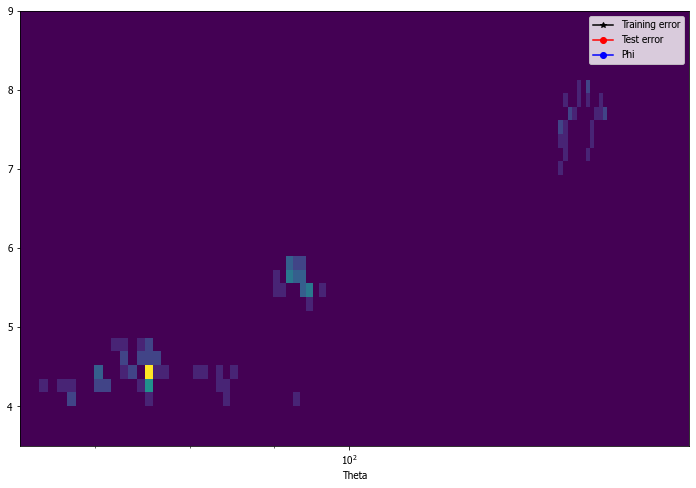

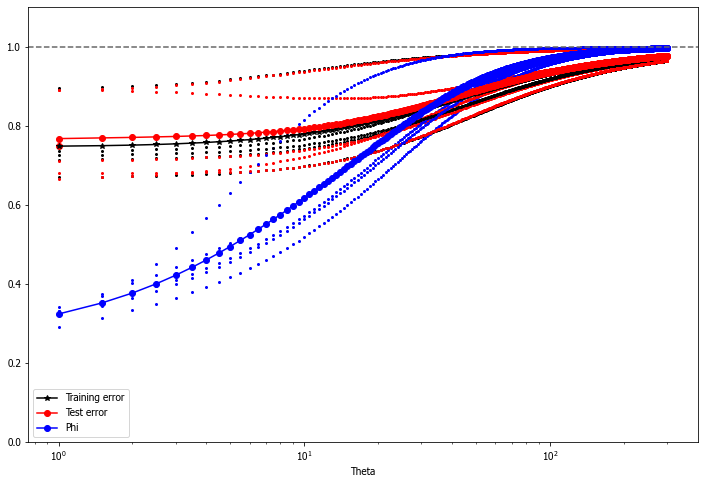

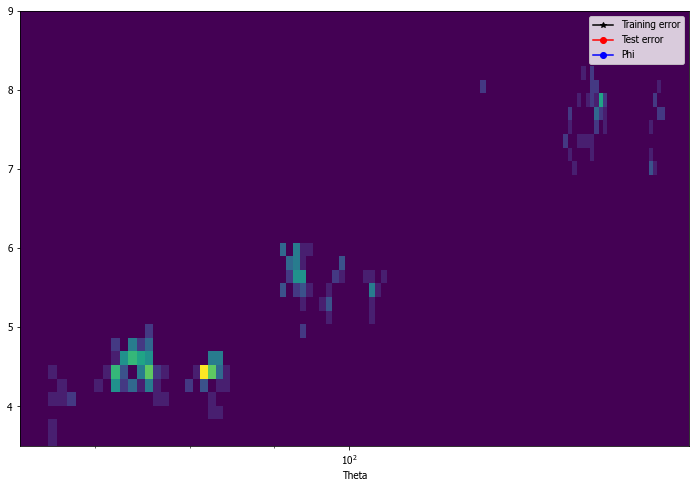

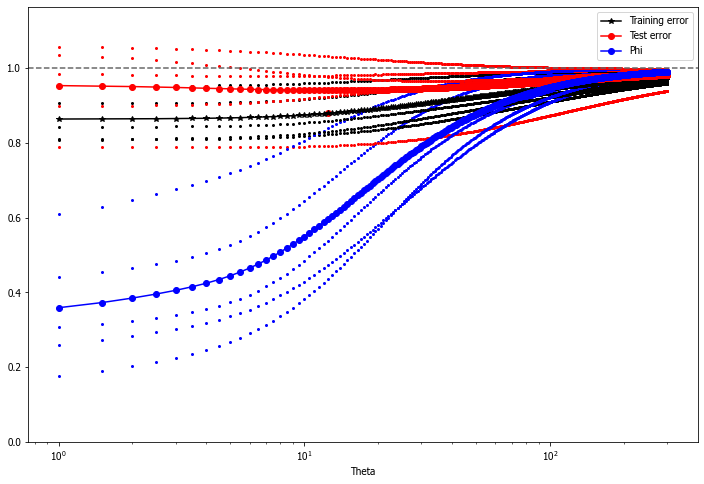

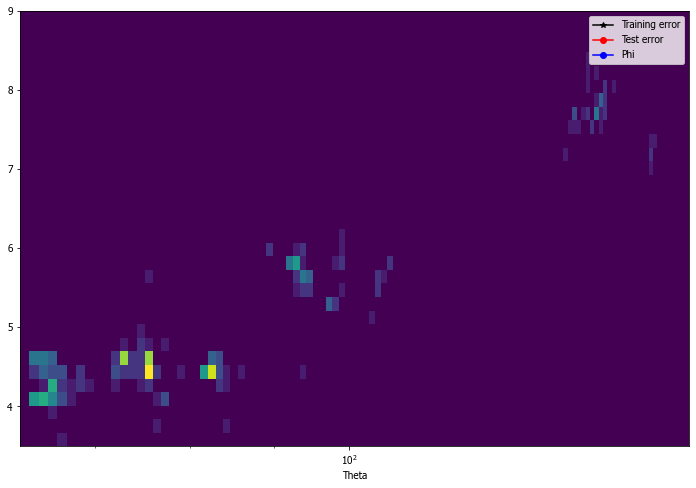

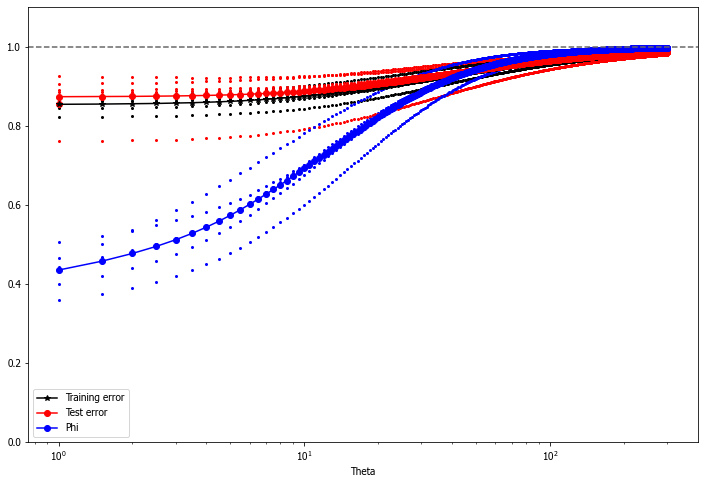

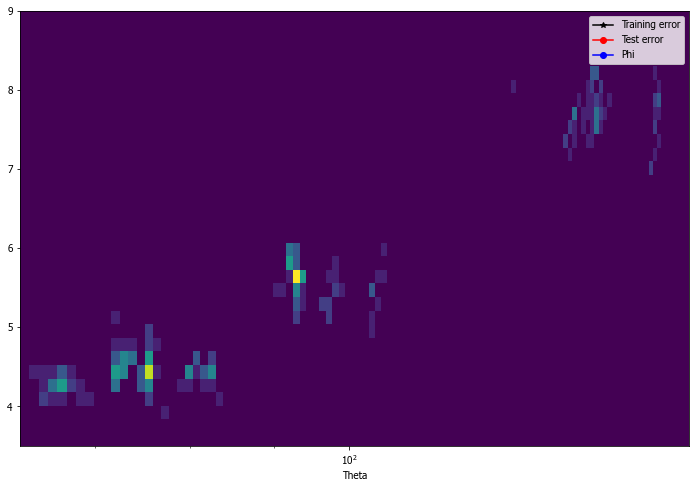

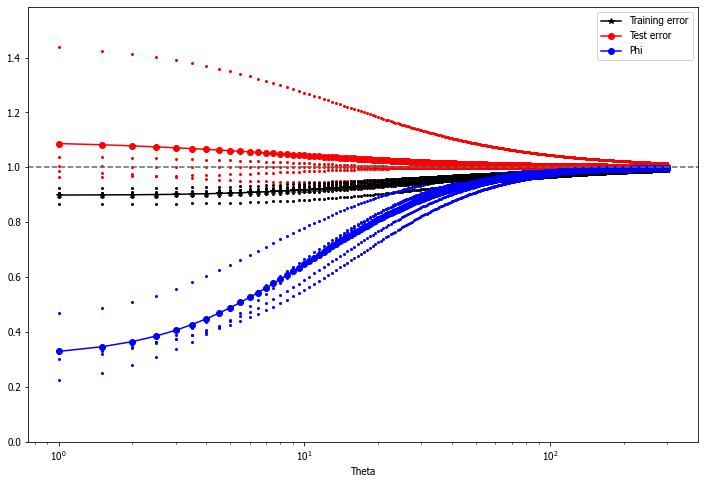

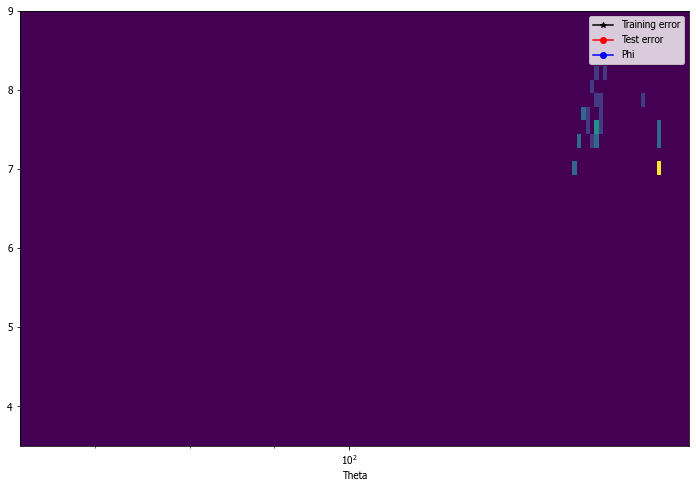

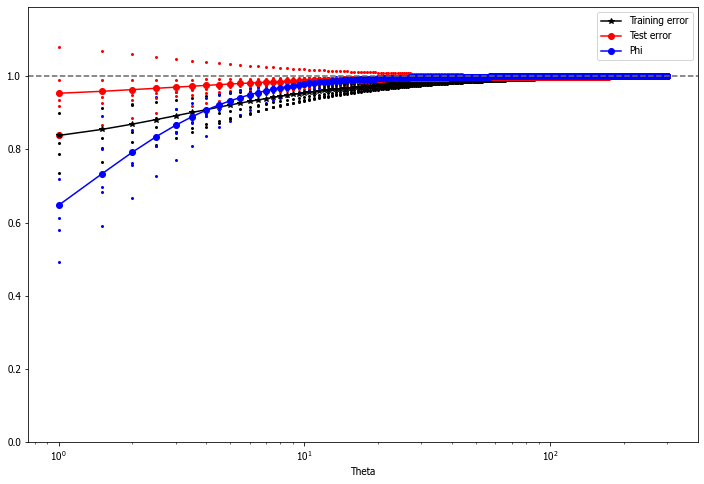

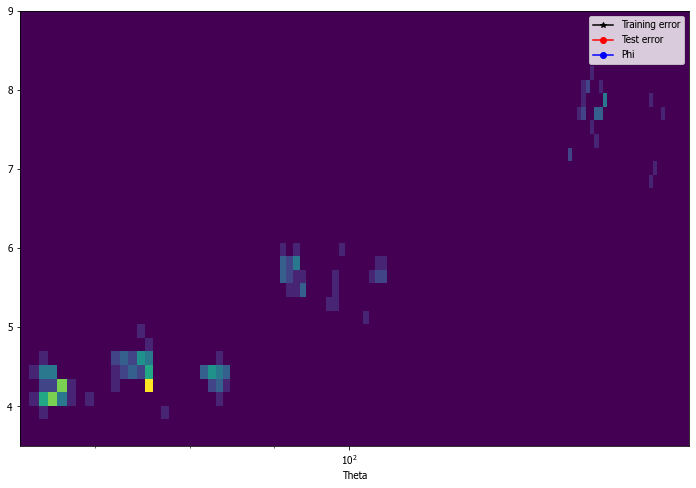

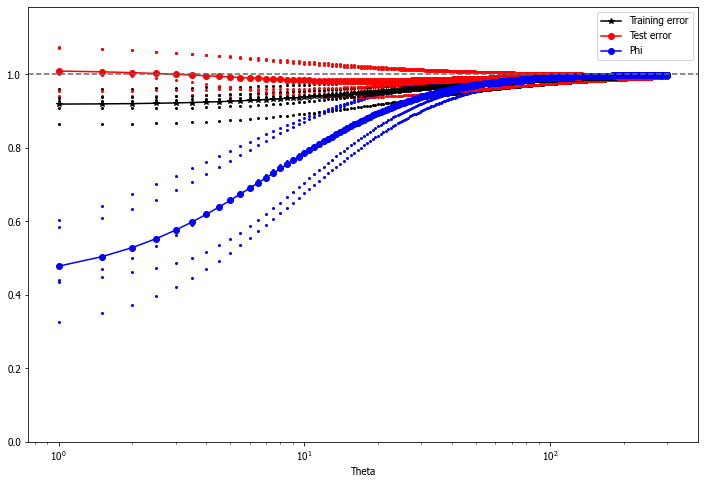

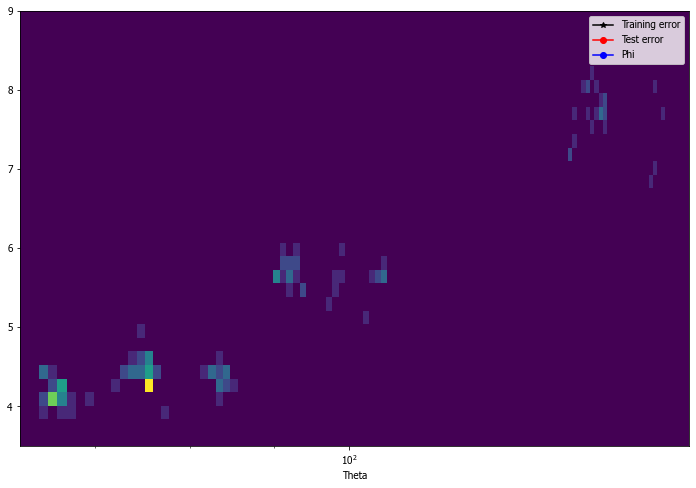

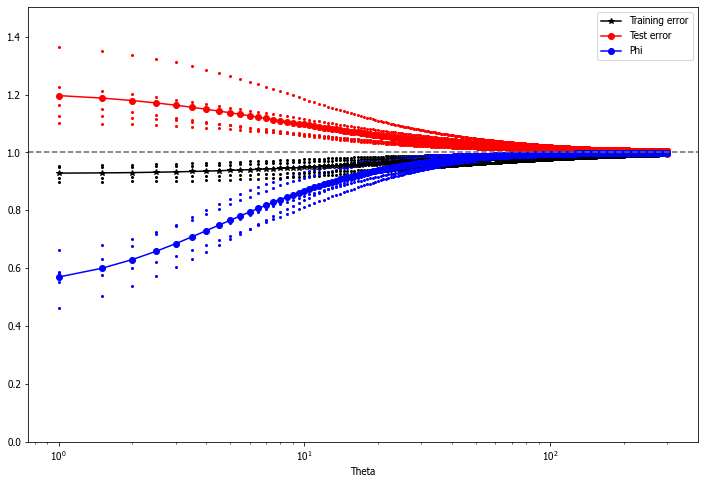

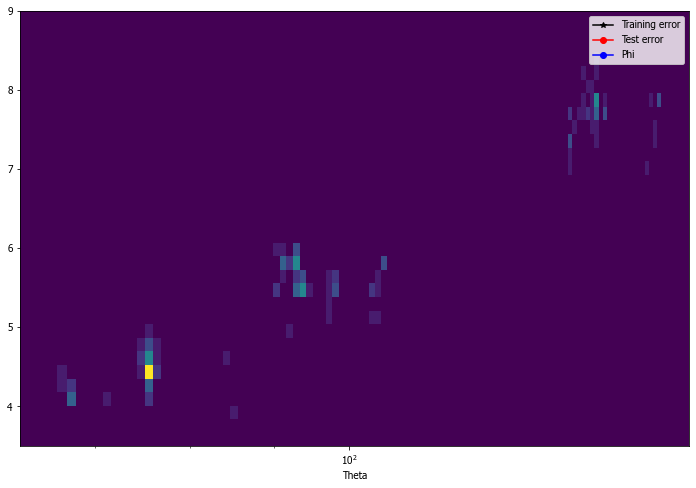

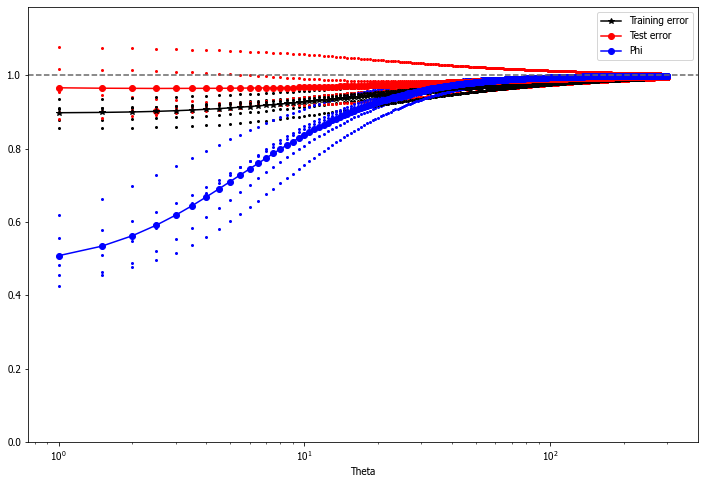

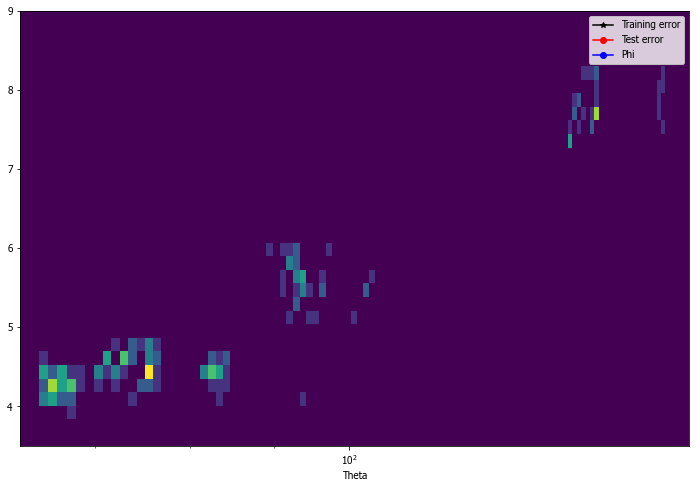

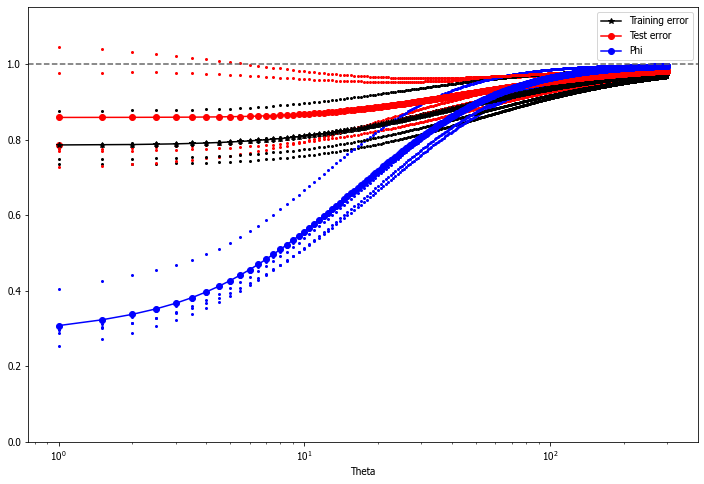

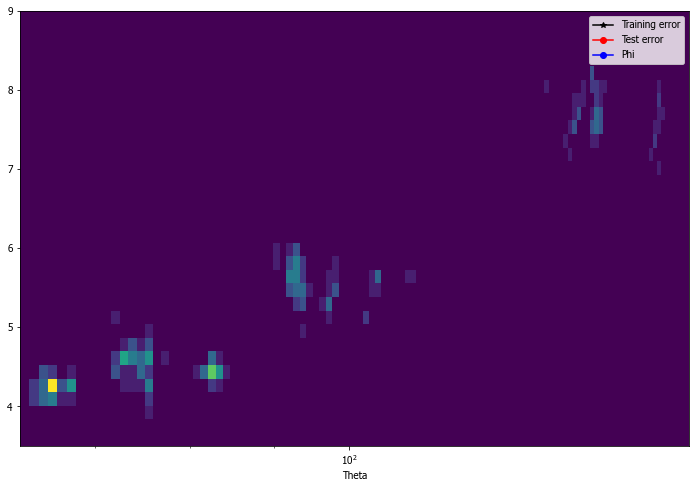

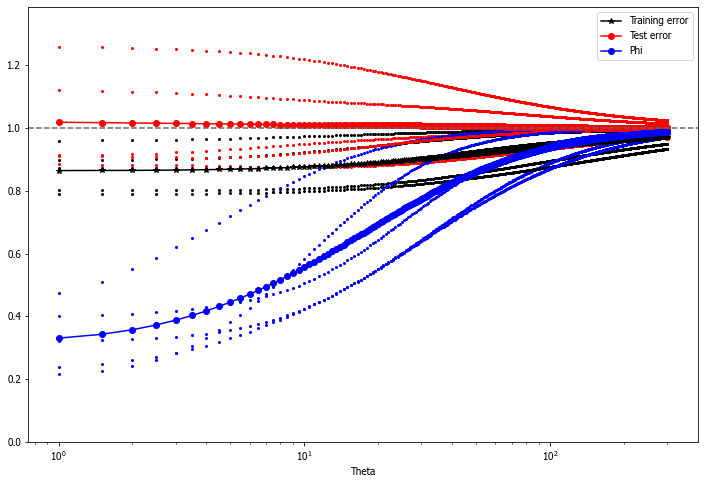

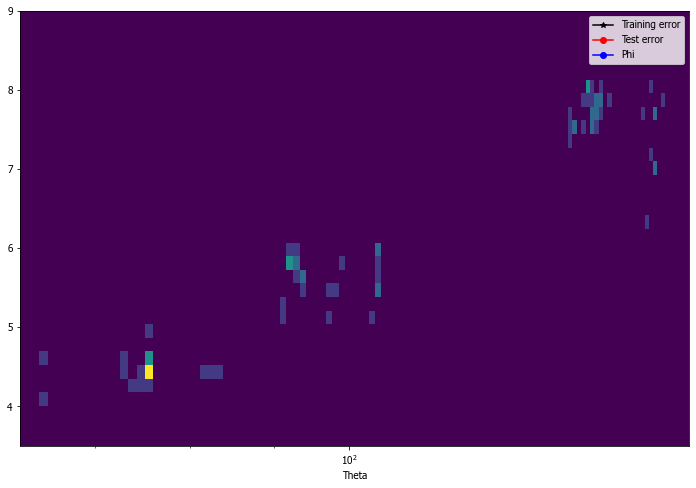

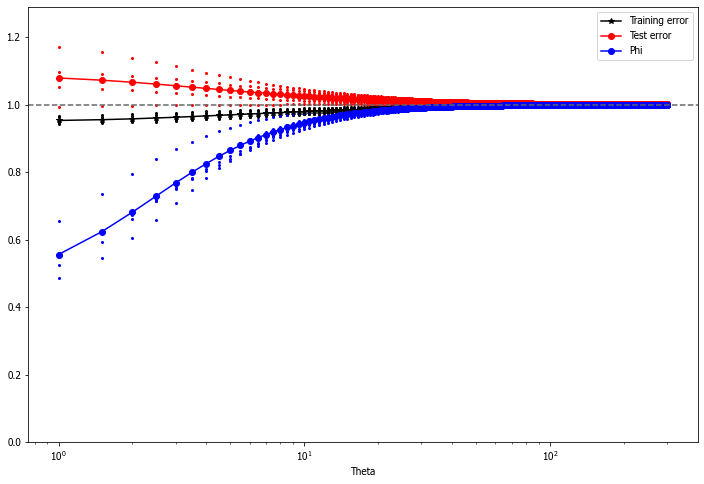

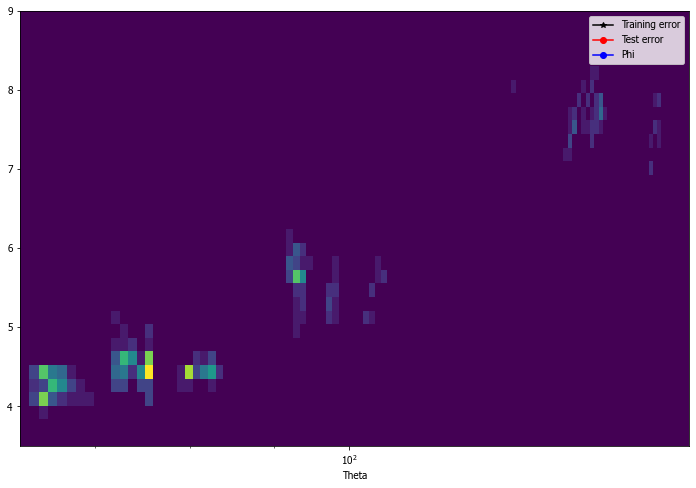

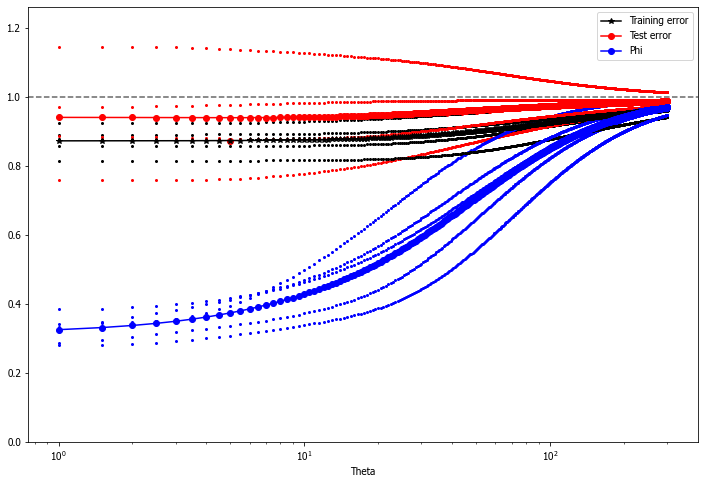

In [6]:
assigned_table, unassigned_table = process_ID_list(ID_list_1, "data/tmp/")

In [7]:
assigned_table.describe()

,Max_Weight_Pos_Assign,Max_Weight_Assign,Chi_2_diff_Assign,Theta_Assign,Effective_Ensemble_Size_A
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,10.333333,0.767164,-0.876399,20.908312,0.302914
std,3.143054,0.248388,0.447369,57.244582,0.231390
min,3.000000,0.282349,-1.644120,1.000000,0.154297
25%,11.000000,0.620227,-1.206995,1.000000,0.173154
50%,11.000000,0.866276,-0.751556,1.000000,0.198883
75%,11.000000,0.972885,-0.557021,2.745614,0.285184
max,16.000000,0.997625,-0.329330,200.000000,0.834799


In [8]:
unassigned_table

,ID,Max_Weight_Pos_Unassign,Max_Weight_Unassign,Chi_2_diff_Unassign,Theta_Unassign,Effective_Ensemble_Size_U
0,1HWQ,11,1.000000,-1.644672,1.000000,0.323764
1,1YMO,11,0.823415,-1.574083,12.480801,0.596331
2,2L3E,11,0.983855,-0.705338,1.000000,0.434884
3,2LU0,11,0.539930,-0.965891,299.500835,0.997806
4,2N6X,11,0.935340,-1.303702,1.000000,0.647002
5,2N7X,6,0.418396,-0.329950,16.973289,0.872999
6,2N82,11,0.154827,-0.271085,300.000000,0.999269
7,2NBY,11,0.954663,-0.568277,2.497496,0.591179
8,2NC0,11,0.969229,-0.676247,1.000000,0.307948
9,5KH8,16,0.115678,-0.222473,299.001669,0.987587


In [9]:
assigned_table.to_csv("data/tmp/assigned_table.csv")
unassigned_table.to_csv("data/tmp/unassigned_table.csv")